In [19]:
# Importing Python libraries
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
from ipywidgets import interact, interactive, fixed
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
def display(img1, img2, lbl1, lbl2, x, y, img3=[], lbl3=[], cmap=None, n = 2):
    """
    Diplay the input images side-by-side.
        Parameters:
            img1: Input image #1.
            img2: Input image #2.
            lbl1: Label for input image #1.
            lbl2: Label for input image #2.
            x, y: Figure size.
            cmap (Default = None): Used to display gray images.
    """
    plt.figure(figsize=(x, y))
    plt.subplot(1, n, 1)
    plt.imshow(img1, cmap = cmap)
    plt.xlabel(lbl1, fontsize=15)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, n, 2)
    plt.imshow(img2, cmap = cmap)
    plt.xlabel(lbl2, fontsize=15)
    plt.xticks([])
    plt.yticks([])
    if n == 3:
        plt.subplot(1, n, 3)
        plt.imshow(img3, cmap = cmap)
        plt.xlabel(lbl3, fontsize=15)
        plt.xticks([])
        plt.yticks([])
    plt.show()

# Camera Calibration
we need to calibrate camera as our test video have curved lanes so to use Distortion Correction we need to know camera parameters

In [25]:
cal_images = glob.glob('camera_cal/*.jpg')
test_images = glob.glob('test_images/*.jpg')

nx, ny = 9, 6
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)


def calibrate_camera(cal_images, nx, ny):
    """
    Compute camera calibration and return the camera intrinsic and extrinsic parameters.
        Parameters:
            cal_images: A list of the chessboard calibration images.
            nx, ny: Chessboard dimensions.
    """
    objpoints = []  # 3D points
    imgpoints = []  # 2D points
    
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1, 2)

    for file in cal_images:
        img = cv2.imread(file)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    return mtx, dist

mtx, dist = calibrate_camera(cal_images, nx, ny)

# Apply Distortion Correction

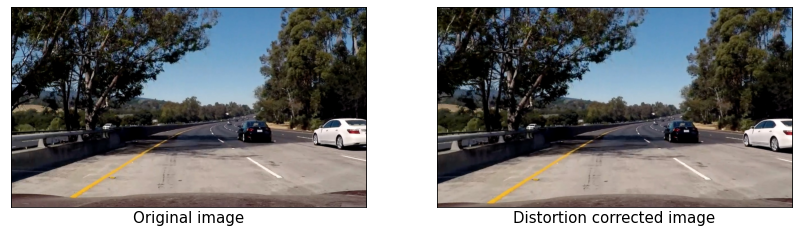

In [26]:
def undistort(img, mtx, dist):
    """
    Use the camera calibration parameters to correct the input image for distortion.
        Parameters:
            img: Input image.
            mtx: Output floating-point camera matrix.
            dist: Output vector of distortion coefficients.
    """
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

# Testing distortion correction on test_images
img = cv2.cvtColor(cv2.imread(test_images[6]), cv2.COLOR_BGR2RGB)
undist_img_ex = undistort(img, mtx, dist)
display(img, undist_img_ex, 'Original image', 'Distortion corrected image', 14, 7)

#### note that testing distortion correction on curved lane to be noticeable

# Apply a Perspective Transform
convert the vehicle’s camera view of the scene into a top-down “bird’s-eye” view

Image shape: (720, 1280, 3)


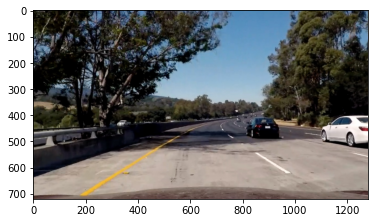

In [27]:
image_shape = undist_img_ex.shape
print("Image shape:", image_shape)
plt.imshow(undist_img_ex)
plt.show()

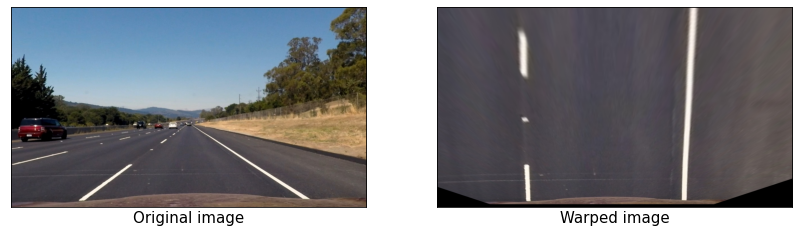

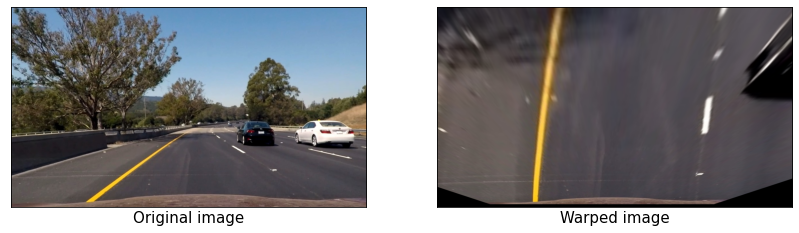

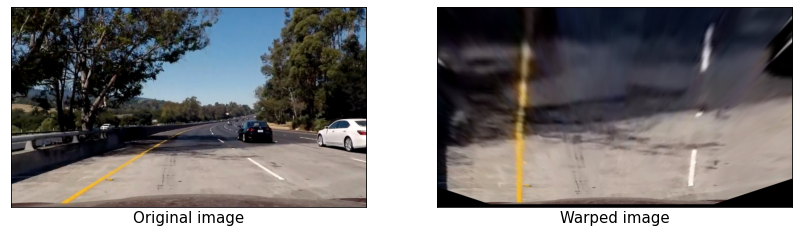

In [28]:
# Define the region of interest
src = np.float32([[190, 700], [1110, 700], [720, 470], [570, 470]])

bottom_left = src[0][0]+100, src[0][1]
bottom_right = src[1][0]-200, src[1][1]
top_left = src[3][0]-250, 1
top_right = src[2][0]+200, 1
dst = np.float32([bottom_left, bottom_right, top_right, top_left])


def perspective_transform(img, src, dst):
    """
     Convert the vehicle’s camera view of the scene into a top-down “bird’s-eye” view.
        Parameters:
            img: Input image.
            src: Source points.
            dst: Destination points.
    """
    image_shape = img.shape
    img_size = (image_shape[1], image_shape[0])
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    # Return the resulting image and matrix
    return warped, M, Minv

# Applying perspective transform to several test_images
display(undistort(cv2.cvtColor(cv2.imread(test_images[1]), cv2.COLOR_BGR2RGB), mtx, dist),
        perspective_transform(undistort(cv2.cvtColor(cv2.imread(test_images[1]), cv2.COLOR_BGR2RGB),
                                        mtx, dist), src, dst)[0],
        'Original image', 'Warped image', 14, 7)
display(undistort(cv2.cvtColor(cv2.imread(test_images[7]), cv2.COLOR_BGR2RGB), mtx, dist),
        perspective_transform(undistort(cv2.cvtColor(cv2.imread(test_images[7]), cv2.COLOR_BGR2RGB),
                                        mtx, dist), src, dst)[0],
        'Original image', 'Warped image', 14, 7)
display(undistort(cv2.cvtColor(cv2.imread(test_images[6]), cv2.COLOR_BGR2RGB), mtx, dist),
        perspective_transform(undistort(cv2.cvtColor(cv2.imread(test_images[6]), cv2.COLOR_BGR2RGB),
                                        mtx, dist), src, dst)[0],
        'Original image', 'Warped image', 14, 7)

undist_example_warped = perspective_transform(undist_img_ex, src, dst)[0]

# Create a Thresholded Binary Image
using color space for lane detection

### LAB Color Space
The Lab color space describes mathematically all perceivable colors in the three dimensions L for lightness and a and b for the color opponents green–red and blue–yellow.

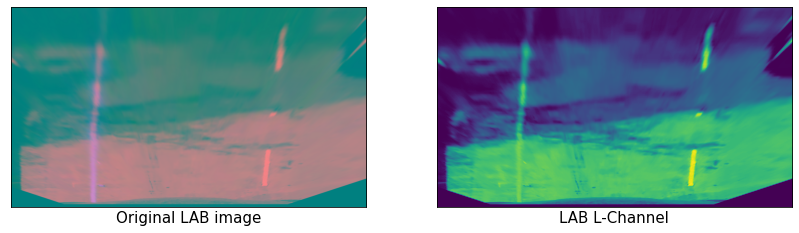

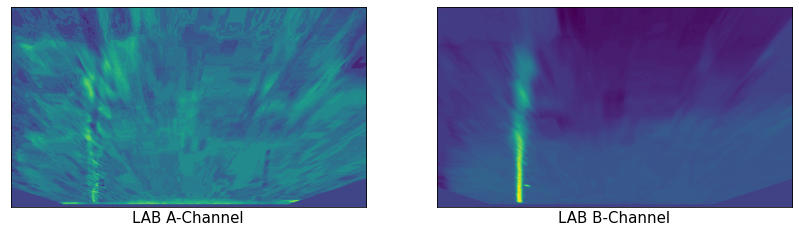

In [31]:
undist_example_RGB = undist_example_warped
undist_example_LAB = cv2.cvtColor(undist_example_RGB, cv2.COLOR_RGB2Lab)
undist_example_LAB_L = undist_example_LAB[:,:,0]
undist_example_LAB_A = undist_example_LAB[:,:,1]
undist_example_LAB_B = undist_example_LAB[:,:,2]

display(undist_example_LAB, undist_example_LAB_L, 'Original LAB image', 'LAB L-Channel', 14, 7)
display(undist_example_LAB_A, undist_example_LAB_B, 'LAB A-Channel', 'LAB B-Channel', 14, 7)

### HLS color space
This model was developed to specify the values of hue, lightness, and saturation of a color in each channel. The difference with respect to the HSV color model is that the lightness of a pure color defined by HLS is equal to the lightness of a medium gray, while the brightness of a pure color defined by HSV is equal to the brightness of white.

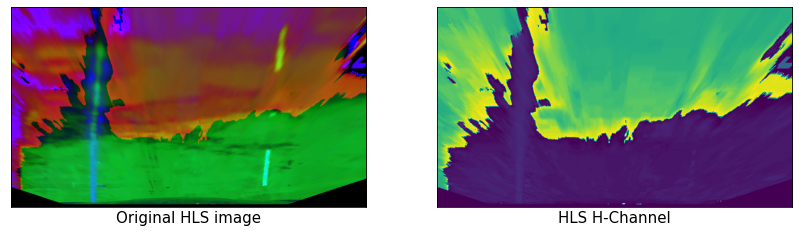

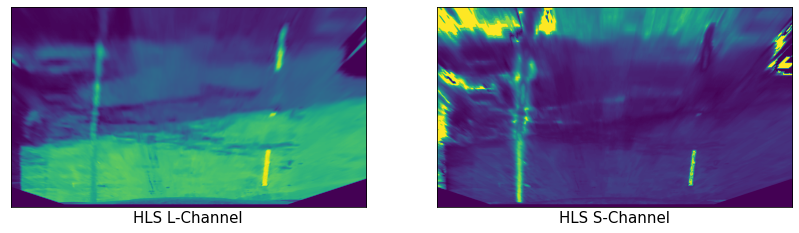

In [32]:
undist_example_HLS = cv2.cvtColor(undist_example_RGB, cv2.COLOR_RGB2HLS)
undist_example_HLS_H = undist_example_HLS[:,:,0]
undist_example_HLS_L = undist_example_HLS[:,:,1]
undist_example_HLS_S = undist_example_HLS[:,:,2]

display(undist_example_HLS, undist_example_HLS_H, 'Original HLS image', 'HLS H-Channel', 14, 7)
display(undist_example_HLS_L, undist_example_HLS_S, 'HLS L-Channel', 'HLS S-Channel', 14, 7)

### Color Space Thresholding
the white lane lines are clearly highlighted in the L-channel of the of the HLS color space, and the yellow line are clear in the B-channel of the LAP color space as well. We'll apply HLS L-threshold and LAB B-threshold to the image to highlight the lane lines.

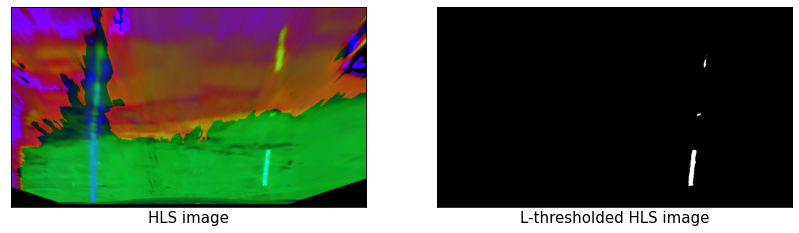

In [33]:
def hls_l_thresh(img, thresh=(220, 255)):
    """
     Threshold the input image to the L-channel of the HLS color space.
        Parameters:
            img: HLS image.
            thresh: Minimum and Maximum color intensity.
    """
    img = img[:,:,1]
    img = img*(255/np.max(img))
    binary_output = np.zeros_like(img)
    binary_output[(img > thresh[0]) & (img <= thresh[1])] = 1
    return binary_output


thresh_HLS = hls_l_thresh(undist_example_HLS)
display(undist_example_HLS, thresh_HLS, 'HLS image', 'L-thresholded HLS image', 14, 7, cmap = 'gray')

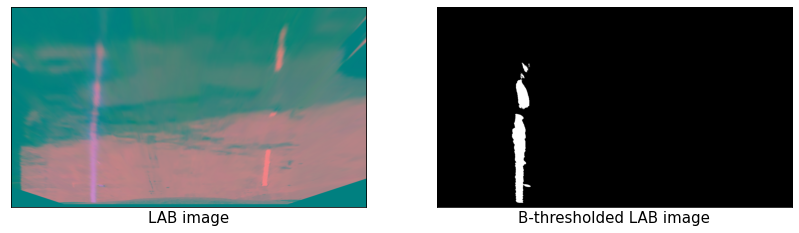

In [34]:
def lab_b_thresh(img, thresh=(190, 255)):
    """
     Threshold the input image to the B-channel of the LAB color space.
        Parameters:
            img: LAB image.
            thresh: Minimum and Maximum color intensity.
    """
    img = img[:,:,2]
    if np.max(img) > 175:
        img = img*(255/np.max(img))
    binary_output = np.zeros_like(img)
    binary_output[(img > thresh[0]) & (img <= thresh[1])] = 1
    return binary_output


thresh_LAB = lab_b_thresh(undist_example_LAB)
display(undist_example_LAB, thresh_LAB, 'LAB image', 'B-thresholded LAB image', 14, 7, cmap = 'gray')

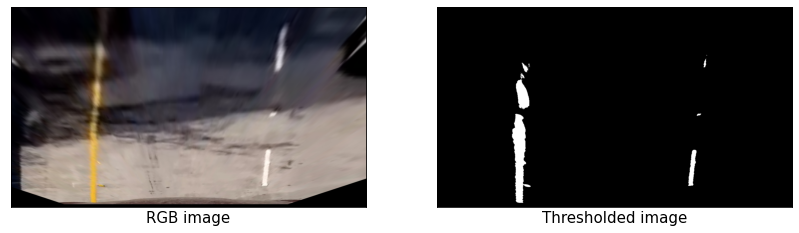

In [35]:
def threshold_color_space(img):
    """
     Threshold the input image to the L-channel of the HLS color space and the B-channel of the LAB color space.
        Parameters:
            img: Input image.
    """
    img_HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    img_LAB = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    img_thresh_HLS = hls_l_thresh(img_HLS)
    img_thresh_LAB = lab_b_thresh(img_LAB)
    combined_img = np.zeros_like(img_thresh_HLS)
    combined_img[((img_thresh_HLS == 1) | (img_thresh_LAB == 1))] = 1
    return combined_img


threshold_color_img = threshold_color_space(undist_example_warped)
display(undist_example_warped, threshold_color_img, 'RGB image', 'Thresholded image', 14, 7, cmap = 'gray')

## Image Processing Pipeline
Distortion Correction then Perspective Transform thenColor Thresholding

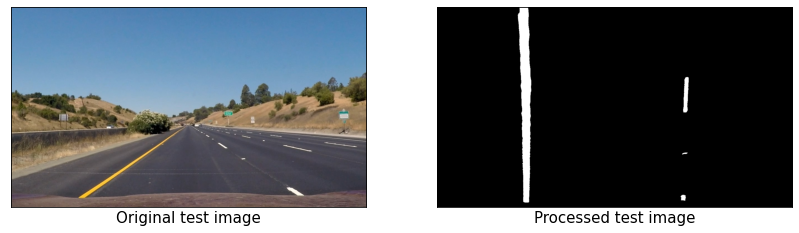

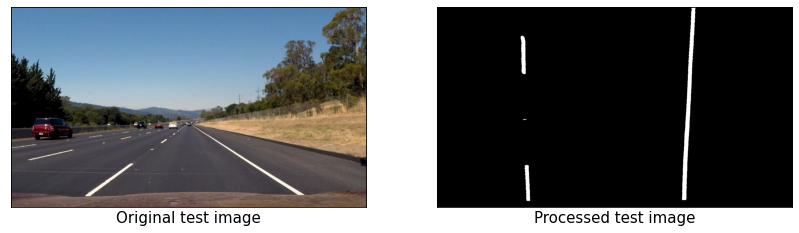

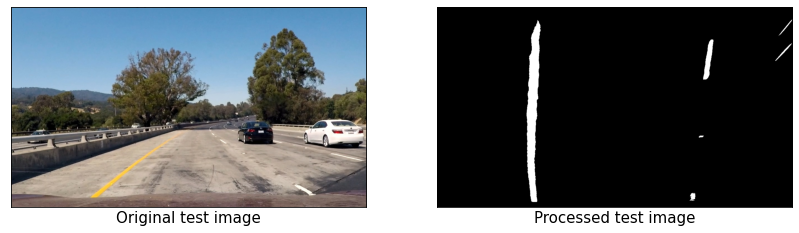

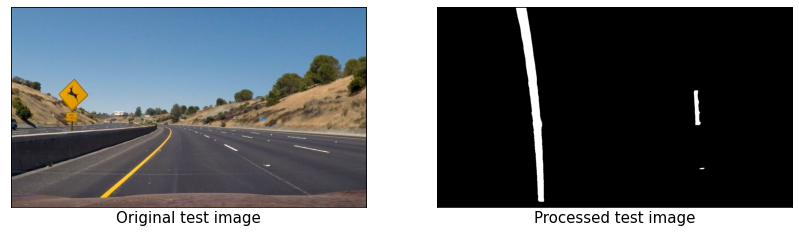

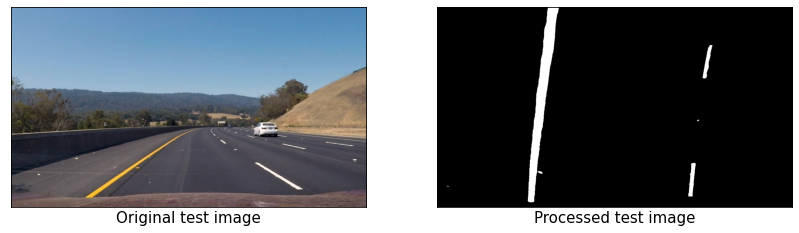

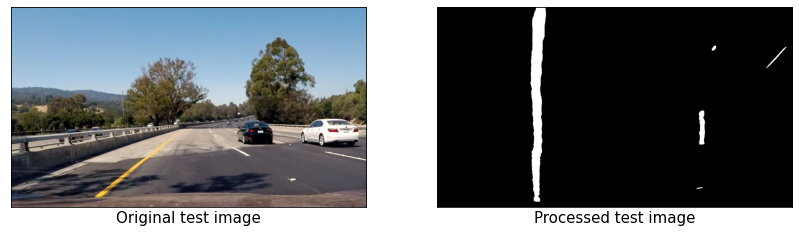

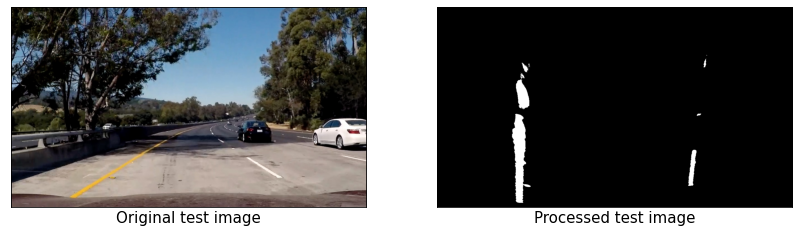

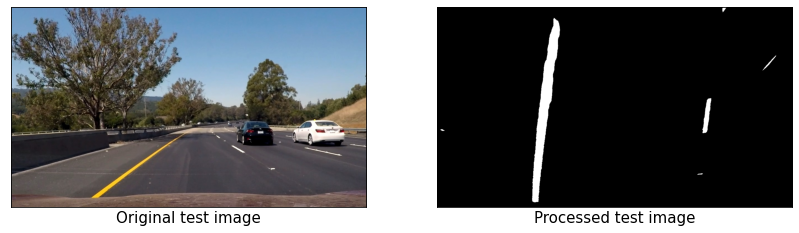

In [36]:
def image_process(img):
    """
    Apply undistortion, perspective transform, and color space thresholding to the input image.
        Parameters:
            img: Input image.
    """
    # Undistort
    img = undistort(img, mtx, dist)
    
    # Perspective Transform
    img, M, Minv = perspective_transform(img, src, dst)

    # Create a thresholded binary image
    img = threshold_color_space(img)
    
    return img, Minv


test_images_imgs = []
test_images_processed = []
for file in test_images:
    image = cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB)
    test_images_imgs.append(image)
    image, Minv = image_process(image)
    test_images_processed.append(image)
    
    
for original, processed in zip(test_images_imgs, test_images_processed):
    display(original,
            processed,
            'Original test image',
            'Processed test image',
            14,
            7,
            cmap='gray')

## Detect the Lane Lines
we still need to decide explicitly which pixels are part of the lines and which belong to the left line and which belong to the right line

### Sliding Window Search
We'll compute a histogram of the bottom half of the image and find the base of the left and right lane lines. Originally these locations were identified from the local maxima of the left and right halves of the histogram, but in the final implementation we used quarters of the histogram just left and right of the midpoint. This helped to reject lines from adjacent lanes. The function identifies 50 windows from which to identify lane pixels, each one centered on the midpoint of the pixels from the window below. This effectively "follows" the lane lines up to the top of the binary image, and speeds processing by only searching for activated pixels over a small portion of the image

In [37]:
def sliding_window(img):
    """
    Fit a polynomial to the input binary image.
        Parameters:
            img: Input image.
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    quarter_point = np.int(midpoint//2)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 50
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &
                          (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &
                           (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data

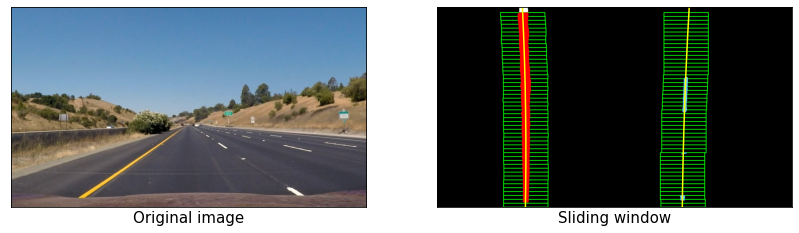

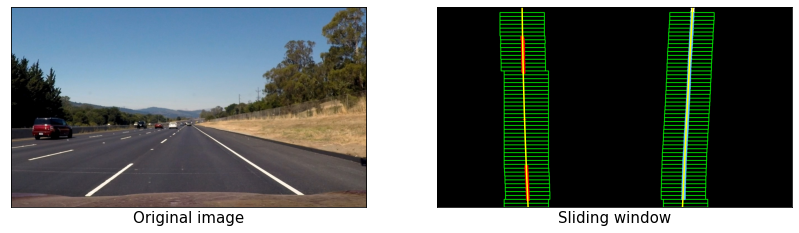

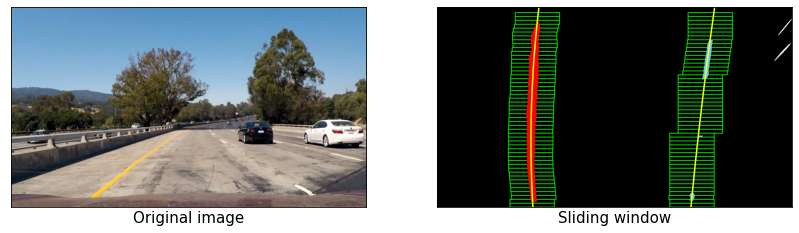

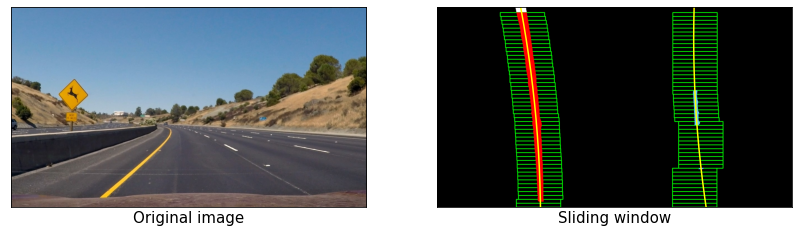

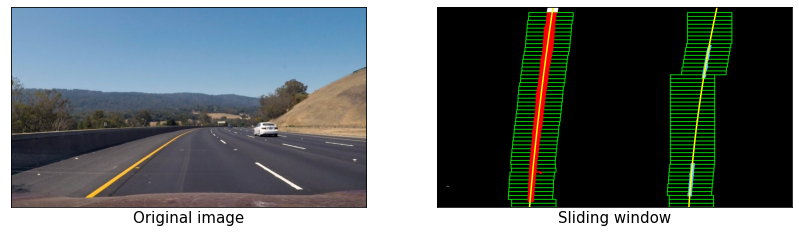

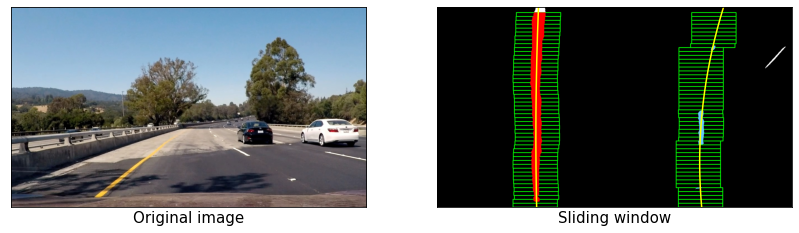

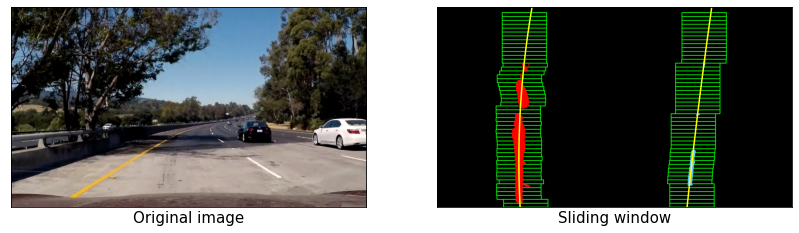

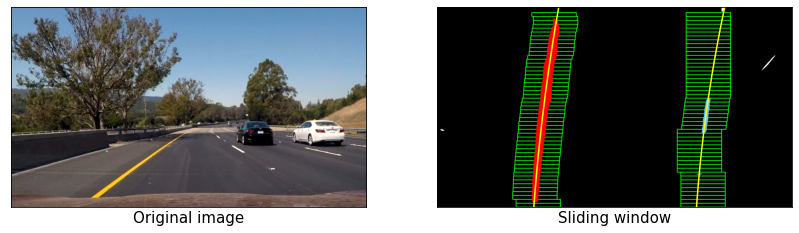

In [38]:
# Visualize the sliding windows over the test images.

for original, processed in zip(test_images_imgs, test_images_processed):
    img = processed
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window(img)
    h = img.shape[0]
    left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
    right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
    rectangles = visualization_data[0]
    histogram = visualization_data[1]
    # Create an output image to draw on and visualize the result
    out_img = np.uint8(np.dstack((img, img, img))*255)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    for rect in rectangles:
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 2) 
        cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 2) 
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.xlabel('Original image', fontsize=15)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(out_img)
    plt.xlabel('Sliding window', fontsize=15)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.xticks([])
    plt.yticks([])
    plt.show()

### Polyfit Using Fit from Previous Frame
The Polyfit Using Fit from Previous Frame is another way that performs basically the same task, but alleviates much difficulty of the search process by leveraging a previous fit (from a previous video frame, for example) and only searching for lane pixels within a certain range of that fit.

In [39]:
def polyfit_prev_fit(img, left_fit_prev, right_fit_prev):
    """
    Fit a polynomial to the input binary image based upon a previous fit.
    This assumes that the fit will not change significantly from one video frame to the next.
        Parameters:
            img: Input image.
            left_fit_prev: 
            right_fit_prev: 
    """
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin))
                & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin))
                & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds

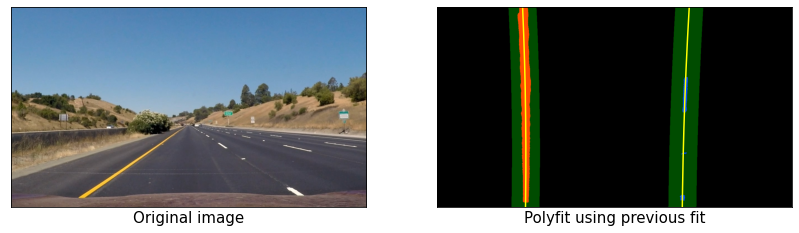

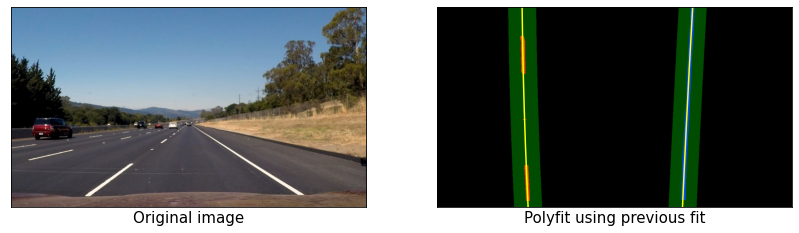

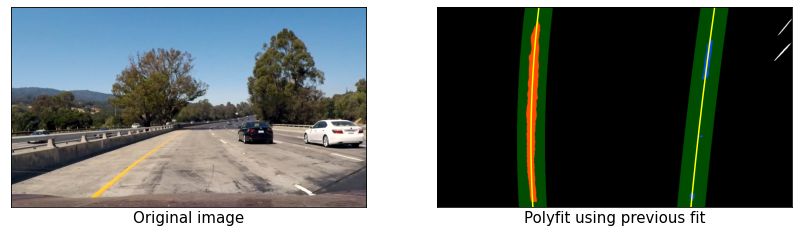

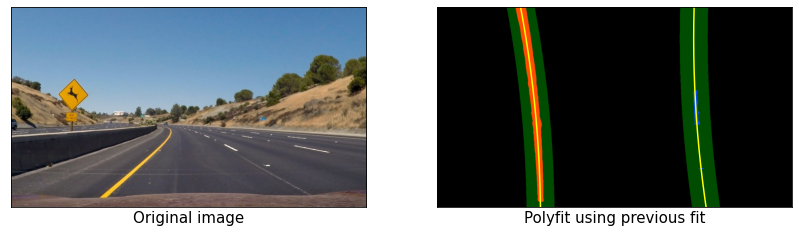

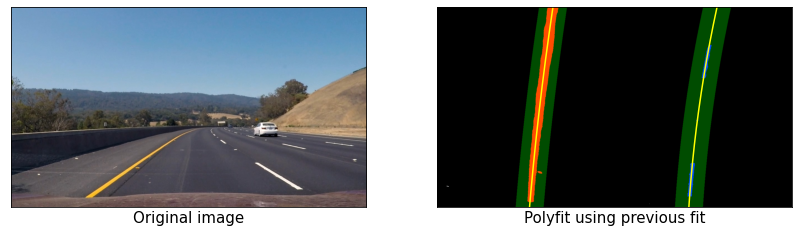

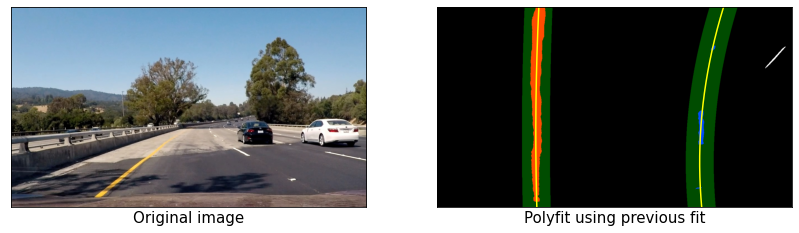

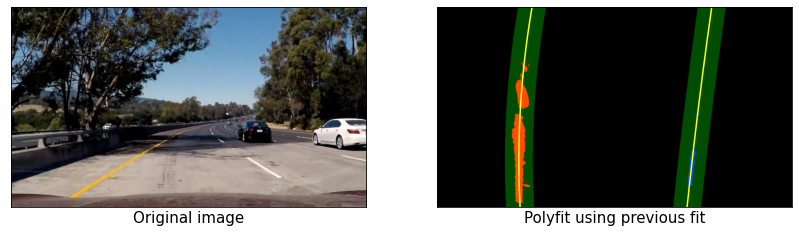

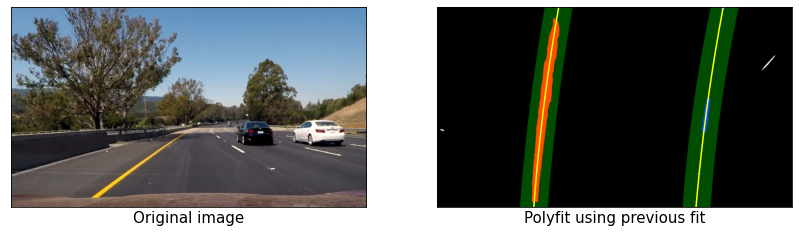

In [40]:
# visualizing polyfit_prev_fit over the test images.

for original, processed in zip(test_images_imgs, test_images_processed):
    img = processed
    margin = 50
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window(img)
    left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_prev_fit(img, left_fit, right_fit)
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
    right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]
    out_img = np.uint8(np.dstack((img, img, img))*255)
    window_img = np.zeros_like(out_img)
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.xlabel('Original image', fontsize=15)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.xlabel('Polyfit using previous fit', fontsize=15)
    plt.plot(left_fitx2, ploty, color='yellow')
    plt.plot(right_fitx2, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.xticks([])
    plt.yticks([])
    plt.show()


## Visual display of the Lane Boundaries


In [41]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    """
    Draw the detected lane over the input image.
        Parameters:
            original_img: Input frame.
            binary_img: Preprocessed image.
            l_fit, r_fit: Detected lanes.
            Minv: Calibration matrix.
    """
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

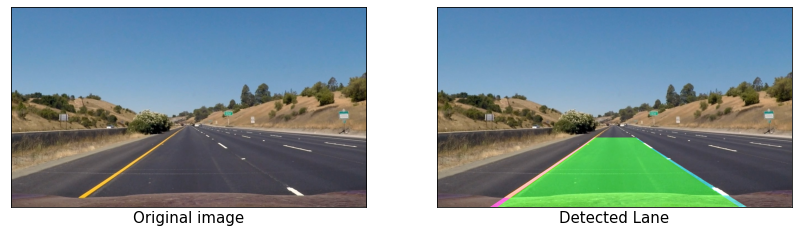

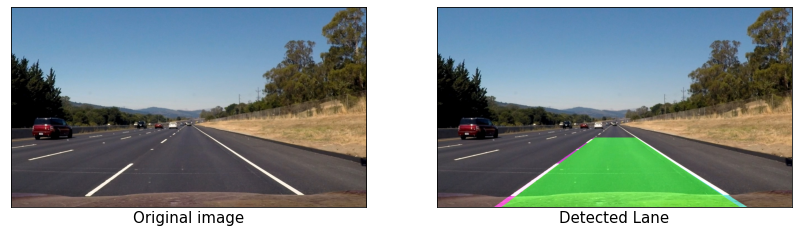

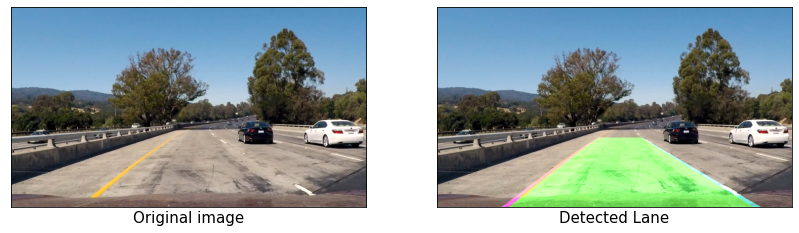

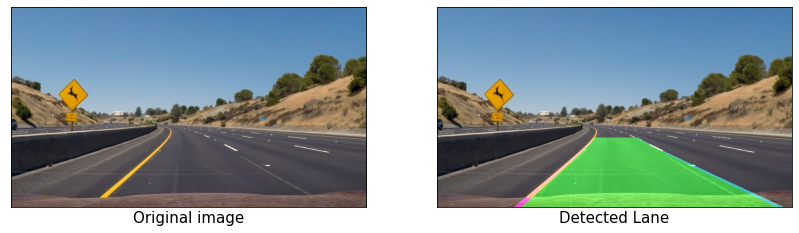

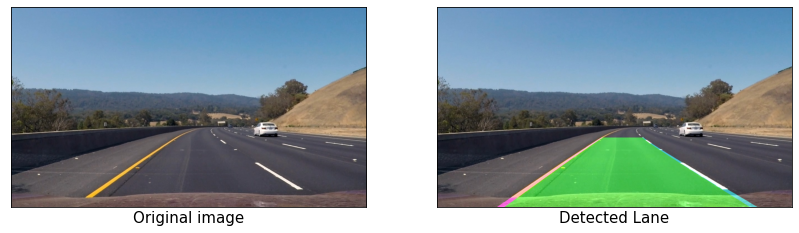

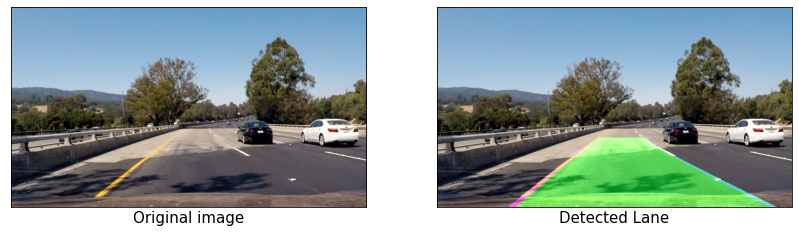

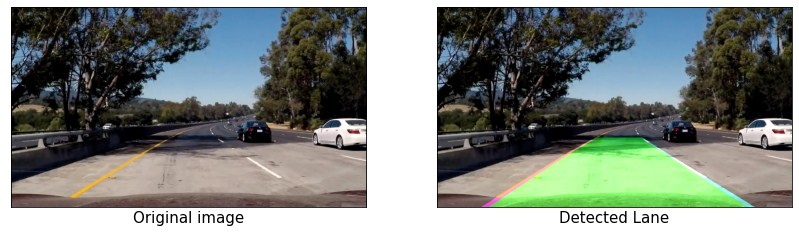

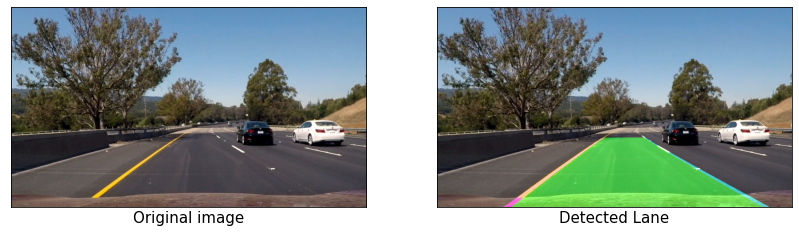

In [43]:
for original, processed in zip(test_images_imgs, test_images_processed):
    left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window(processed)
    left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_prev_fit(processed, left_fit, right_fit)
    result = draw_lane(original, processed, left_fit, right_fit, Minv)
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(original)
    plt.xlabel('Original image', fontsize=15)
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.xlabel('Detected Lane', fontsize=15)
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    plt.xticks([])
    plt.yticks([])
    plt.show()